In [1]:
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import os
from os import listdir
import gdown
from zipfile import ZipFile
import pickle
import cv2
from os import listdir

In [2]:
from tensorflow.keras.utils import img_to_array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            img_gan = cv2.resize(image, (32,32))
            return img_to_array(img_gan)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [25]:
def extract_plant_imgs(directory_root, num):
    image_list, label_list = [], []
    try:
        print("[INFO] Loading images ...")
        root_dir = listdir(directory_root)
        #print(root_dir)
        for plant_folder in root_dir :
            # remove .DS_Store from list
            if plant_folder == ".DS_Store" :
                root_dir.remove(directory)


        for plant_folder in root_dir :
    #         print("on plant folder")
            plant_image_list = listdir(f"{directory_root}/{plant_folder}")



            for single_image in plant_image_list :

    #             print("in plant folder")
                if single_image == ".DS_Store" :
                    plant_image_list.remove(single_image)

            for image in plant_image_list[:num]:
    #             print("getting img path")
                image_directory = f"{directory_root}/{plant_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".png") == True or image_directory.endswith(".PNG") == True:
    #                 print("checking if img correct format")
                    gan_img = convert_image_to_array(image_directory)
                    image_list.append(gan_img)
                    label_list.append(plant_folder)

        print("[INFO] Image loading completed")
        return image_list, label_list
    except Exception as e:
        print(f"Error : {e}")

In [4]:
orignal_data = 'Orignal_cherry'
enhanced_data = 'Enhanced_cherry_LSGAN'

orignal_image_list , orignal_label_list = extract_plant_imgs(orignal_data)

[INFO] Loading images ...
[INFO] Image loading completed


In [5]:
enhanced_image_list , enhanced_label_list = extract_plant_imgs(enhanced_data)
print(len(enhanced_image_list))

[INFO] Loading images ...
[INFO] Image loading completed
2000


In [6]:
combined_image_list = orignal_image_list + enhanced_image_list
print(len(combined_image_list))

4000


In [7]:
combined_label_list = orignal_label_list + enhanced_label_list
print(len(combined_label_list))

4000


In [8]:
new_image_list = np.array(combined_image_list, dtype = np.float16) / 255.0
print(new_image_list.shape)

(4000, 32, 32, 3)


In [9]:
combined_label_list = orignal_label_list+enhanced_label_list

In [10]:
from sklearn.preprocessing import LabelBinarizer
label_gen = LabelBinarizer()
image_labels = label_gen.fit_transform(combined_label_list)
pickle.dump(label_gen,open('label_transform.pkl', 'wb'))
n_classes = len(label_gen.classes_)
print(n_classes)
print(image_labels)

2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [11]:
from sklearn.model_selection import train_test_split
print("making the training and testing split with 30% of the dataset as testing set")
x_train, x_test, y_train, y_test = train_test_split(new_image_list, image_labels, test_size=0.3, shuffle=True,random_state = 42) 
print(x_train.shape)
print(x_test.shape)

making the training and testing split with 30% of the dataset as testing set
(2800, 32, 32, 3)
(1200, 32, 32, 3)


In [12]:
def convert_to_2D(set_shape):
    num_images, height, width, channels = set_shape.shape
    converted_shape = np.reshape(set_shape, (num_images, height * width * channels))
    return converted_shape

def convert_to_1D(set_shape):
    converted_shape = set_shape.flatten()
    return converted_shape

In [13]:
x_train_2D = convert_to_2D(x_train)
x_test_2D = convert_to_2D(x_test)
y_train_1D = convert_to_1D(y_train)
y_test_1D = convert_to_1D(y_test)

In [14]:
# Create a Random Forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100)
# x_train = x_train.flatten()
# Fit the classifier to the training data
rfc.fit(x_train_2D, y_train_1D)


RandomForestClassifier()

In [15]:
pickle.dump(rfc,open('combined_cherry_LSGAN','wb'))

In [16]:
orignal_RF = pickle.load(open('combined_strawberry_BiGANxSRGAN','rb'))


In [17]:
y_pred = rfc.predict(x_test_2D)

# Calculate the accuracy of the classifier

y_pred = np.where(y_pred[:len(x_test_2D)] >= 0.5, 1, 0)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# print("Accuracy:", accuracy * 100)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
# Calculate the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Print the precision, recall, f1-score, and confusion matrix.
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy * 100)
print("Confusion matrix:\n", cm)

Precision: 0.9891666666666667
Recall: 0.9892767539363023
F1-score: 0.9891660572573875
Accuracy: 98.91666666666666
Confusion matrix:
 [[598  11]
 [  2 589]]


In [28]:
# below is attempt on creating a function to perform the above iterations

In [37]:
def train_model(img_list, lab_list, orig_img, orig_lab):
    new_list = np.array(img_list, dtype = np.float16) / 255.0
    print(new_list.shape)
    
    label_gen = LabelBinarizer()
    im_labels = label_gen.fit_transform(lab_list)
    pickle.dump(label_gen,open('label_transform.pkl', 'wb'))
    n_classes = len(label_gen.classes_)
    print(n_classes)
    print(image_labels)
    
    norm_orig_list = np.array(orig_img, dtype = np.float16) / 255.0
    
    label_gen = LabelBinarizer()
    orig_list_lab = label_gen.fit_transform(orig_lab)
    pickle.dump(label_gen,open('label_transform.pkl', 'wb'))
    n_classes = len(label_gen.classes_)
    print(n_classes)
    print(image_labels)
    
    from sklearn.model_selection import train_test_split
    print("making the training and testing split with 30% of the dataset as testing set")
    orig_x_train, orig_x_test, orig_y_train, orig_y_test = train_test_split(norm_orig_list, orig_list_lab, test_size=0.3, shuffle=True,random_state = 42) 
   
    orig_test_x_2D = convert_to_2D(orig_x_test)
    orig_test_y_1D = convert_to_1D(orig_y_test)
    
    from sklearn.model_selection import train_test_split
    print("making the training and testing split with 30% of the dataset as testing set")
    x_train, x_test, y_train, y_test = train_test_split(new_list, im_labels, test_size=0.3, shuffle=True,random_state = 42) 
    print(x_train.shape)
    print(x_test.shape)
    
    x_train_2D = convert_to_2D(x_train)
    y_train_1D = convert_to_1D(y_train)
    
    # Create a Random Forest classifier with 100 trees
    print("trianing forest")
    rfc = RandomForestClassifier(n_estimators=100)
    # x_train = x_train.flatten()
    # Fit the classifier to the training data
    rfc.fit(x_train_2D, y_train_1D)

    
    
    return rfc, orig_test_x_2D, orig_test_y_1D


In [38]:
def get_result(model,x_test, y_test):
    y_prob = model.predict(x_test)
    y_pred = np.where(y_prob[:len(x_test_2D)] >= 0.5, 1, 0)

    # y_pred = model.predict(x_test)
    # print(y_pred)
    # # mse = mean_squared_error(y_test, y_pred)
    # # print(mse)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return accuracy

In [39]:
import matplotlib.pyplot as plt

def generate_performance_graph(type_dataset, original_path):
    # Define the number of images to use in each iteration
    num_images = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    
    # Initialize an empty list to store the performance metrics
    performance_metrics = []
    
    # Train the model iteratively with increasing number of images and collect the performance metrics
    for n in num_images:
        # Load the dataset with n images
        type_image_list , type_label_list = extract_plant_imgs(type_dataset,1000)
        orignal_image_list , orignal_label_list = extract_plant_imgs(original_path,n)
        orig_img , orig_lab = extract_plant_imgs(original_path,1000)
#         dataset = load_dataset(n)
        combined_img_list = type_image_list + orignal_image_list
        combined_label_list = type_label_list + orignal_label_list
        
        # Train the model with the dataset and get the performance metric
        model, x_test, y_test = train_model(combined_img_list, combined_label_list, orig_img, orig_lab)
        
        accuracy = get_result(model, x_test, y_test)
        
        # Store the performance metric in the list
        performance_metrics.append(accuracy)
    
    # Generate the graph
    return performance_metrics, num_images


In [40]:
def plot_graph(performance_metrics, num_images, title):
    plt.plot(num_images, performance_metrics)
    plt.title(title)
    plt.xlabel('Number of Images')
    plt.ylabel('Accuracy')
#     plt.bar(num_images,performance_metrics)
    plt.savefig(title + 'RF')
    plt.show()

Enhanced_strawberry_DCGAN
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2000, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1400, 32, 32, 3)
(600, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2200, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1540, 32, 32, 3)
(660, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[INFO] I

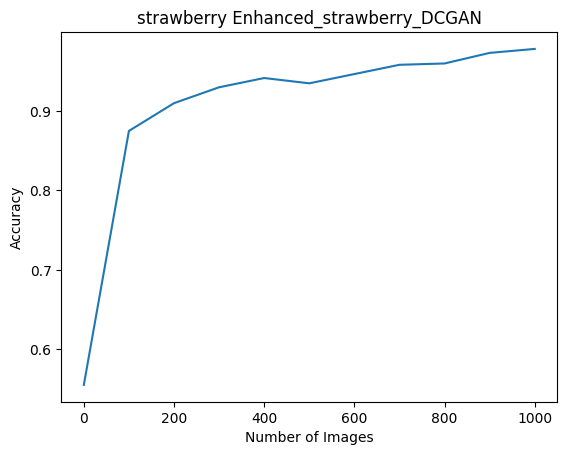

Enhanced_strawberry_DCGANxSRGAN
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2000, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1400, 32, 32, 3)
(600, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2200, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1540, 32, 32, 3)
(660, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[I

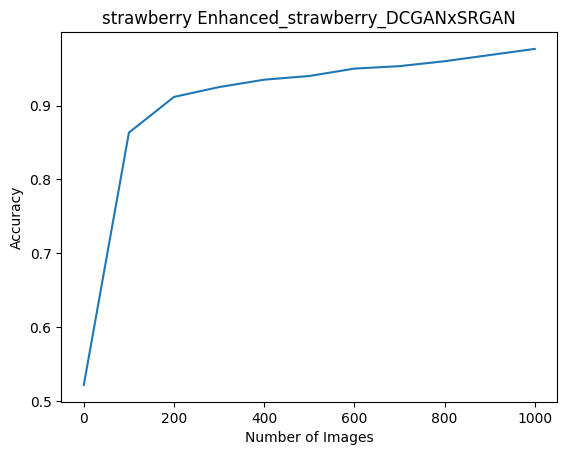

Enhanced_strawberry_LSGAN
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2000, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1400, 32, 32, 3)
(600, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2200, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1540, 32, 32, 3)
(660, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[INFO] I

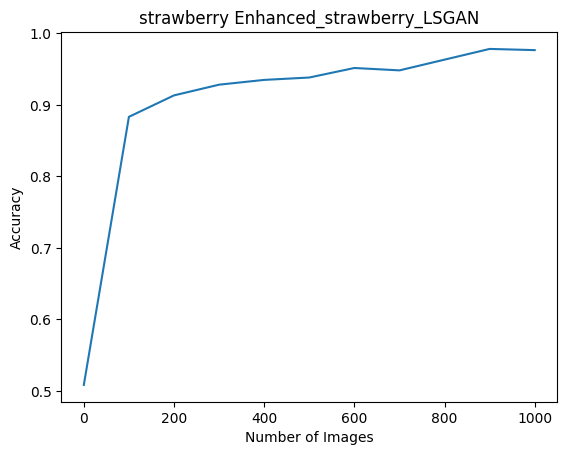

Enhanced_strawberry_LSGANxSRGAN
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2000, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1400, 32, 32, 3)
(600, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2200, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1540, 32, 32, 3)
(660, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[I

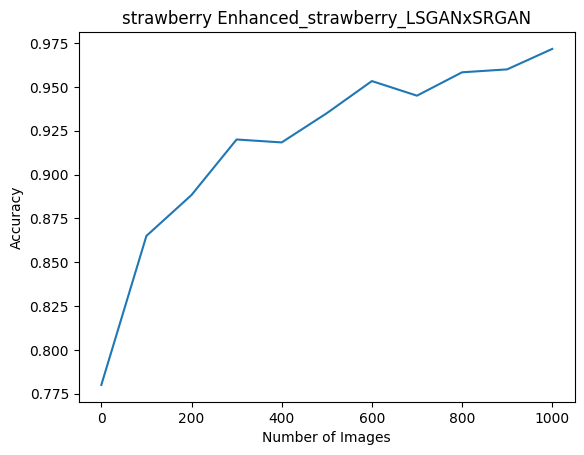

Enhanced_strawberry_WGAN
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2000, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1400, 32, 32, 3)
(600, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2200, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1540, 32, 32, 3)
(660, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[INFO] Im

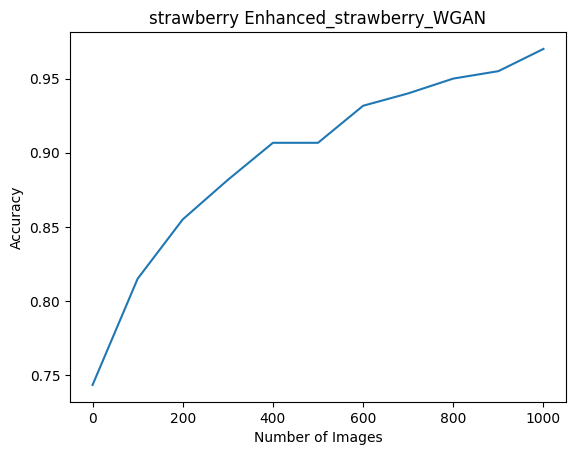

Enhanced_strawberry_WGANxSRGAN
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2000, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1400, 32, 32, 3)
(600, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2200, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1540, 32, 32, 3)
(660, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[IN

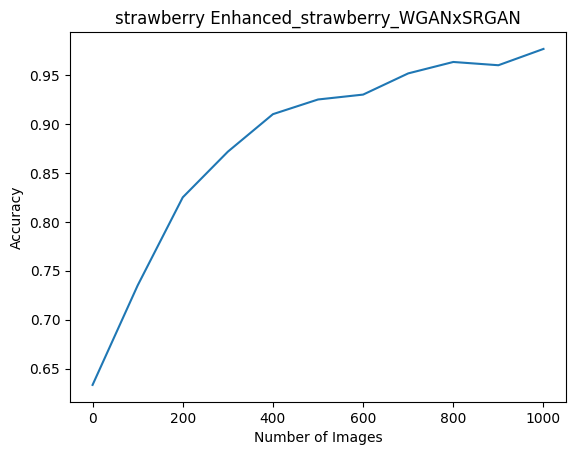

Enhanced_strawberry_BiGAN
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2000, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1400, 32, 32, 3)
(600, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2200, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1540, 32, 32, 3)
(660, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[INFO] I

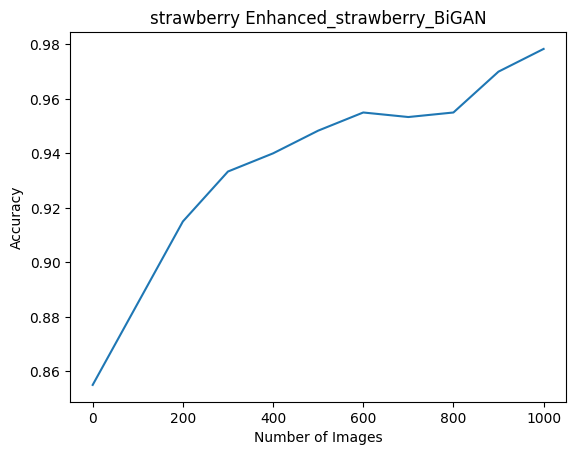

Enhanced_strawberry_BiGANxSRGAN
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2000, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1400, 32, 32, 3)
(600, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
[INFO] Loading images ...
[INFO] Image loading completed
(2200, 32, 32, 3)
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
making the training and testing split with 30% of the dataset as testing set
making the training and testing split with 30% of the dataset as testing set
(1540, 32, 32, 3)
(660, 32, 32, 3)
trianing forest
[INFO] Loading images ...
[I

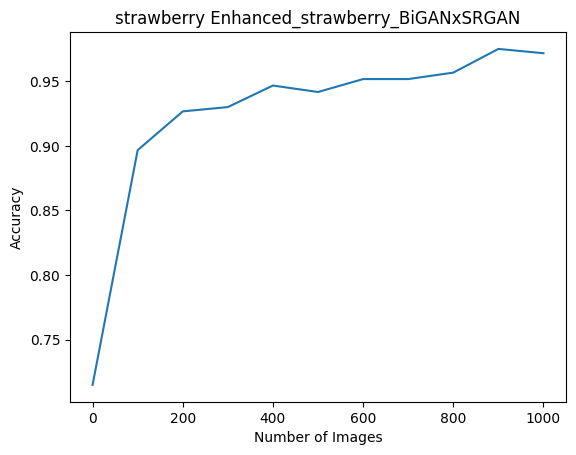

In [45]:
types_gans = ['Enhanced_strawberry_DCGAN', 'Enhanced_strawberry_DCGANxSRGAN', 
              'Enhanced_strawberry_LSGAN', 'Enhanced_strawberry_LSGANxSRGAN',
              'Enhanced_strawberry_WGAN', 'Enhanced_strawberry_WGANxSRGAN', 
              'Enhanced_strawberry_BiGAN', 'Enhanced_strawberry_BiGANxSRGAN']

for names in types_gans:
    print(names)
    type_gan_path = names
    title_gan = 'strawberry ' + names 
    orig_plant_path = 'Orignal_strawberry'
    
    perf_list, n_list = generate_performance_graph(type_gan_path, orig_plant_path)
    plot_graph(perf_list, n_list, title_gan)